In [8]:
osi_threshold = 0.4
dsi_threshold = 0.3
#tf_for_dsi_calc = 2.0
# ecid = 511510650
# ecid,eid pairs
eids = [(511510650,501836392), (511510650,501886692), (511510650,501717543)]
# 501836392 501886692 501717543

# Events or dff
use_events = True
# Only pairs that are closer than these frames will be considered.
# For reference, ko 2011 did 50um. Each 512 pixel field of view is 400 um. 64frames =50um.
max_d = 64
# So we don't cheat and reuse the same cell, since there are some segmentation errors.
# And, to reduce the confound of fluorescence affecting neighbors 
min_d = 5
# corr_type = TEMP_CORR_AVG, AVG_TEMP_CORR, NOISE_CORR
# Ho ko 2011 used TEMP_CORR_AVG for signal correlation.
# "Signal correlation was calculated as the correlation coefficient of the average responses to stimulus."
# Then, NOISE_CORR for noise correlation.
# "Noise correlation was found by subtracting the average response from the responses"
corr_type = 'NOISE_CORR'

In [9]:
import os
drive_path = '/media/stephen/Brain20191/allen-brain-observatory/visual-coding-2p/'
if not os.path.isdir(drive_path):
    drive_path = '/media/alihamodi/Brain2019/allen-brain-observatory/visual-coding-2p/'

import warnings; warnings.simplefilter('ignore');
from utils.polarplot import *
from utils.polardata import *
from utils.data_wrappers import *
import os
import pandas as pd
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import allensdk.brain_observatory.stimulus_info as stim_info
manifest_file = os.path.join(drive_path,'manifest.json')
boc = BrainObservatoryCache(manifest_file=manifest_file)

import warnings;
warnings.simplefilter('ignore');
cells = boc.get_cell_specimens()
cells = pd.DataFrame.from_records(cells)
    
# Outputs = [cell_specimen_id, experiment_container_id, pref_dir]
#pd.DataFrame(boc.get_ophys_experiments(experiment_container_ids=[ecid]))
0

0

In [10]:
def get_dir_pairs_to_corrs_one_exp(boc, cells, ecid, eid):
    print("Processing ecid {}, eid {}".format(ecid, eid))
    dg_response_filter = get_dg_response_filter_from_saskia()
    filtered_cells = get_filtered_cells(cells, dg_response_filter)
    filtered_cells = filtered_cells[filtered_cells.experiment_container_id==ecid]
    data_set = boc.get_ophys_experiment_data(eid)

    # Filter out based on tf-specific-dsi, rather than allen's global dsi
    # Also recalculate preferred direction using specific tf.
    """
    tf_specific_dsi_col = []
    tf_specific_pref_dir_col = []
    for index, row in filtered_cells.iterrows():
        polardata_for_this_cell = get_avg_normalized_response(
            data_set = data_set,
            cell_specimen_id = row.cell_specimen_id,
            temporal_frequency = tf_for_dsi_calc)
        if polardata_for_this_cell is None:
            # Put negative value so dsi selector will ignore this guy.
            new_dsi_cell = -1
        else:
            new_dsi_cell = get_new_dsi(polardata_for_this_cell.to_frame())
        tf_specific_dsi_col.append(new_dsi_cell)
        tf_specific_pref_dir_col.append(polardata_for_this_cell.argmax())
    filtered_cells['tf_specific_dsi'] = tf_specific_dsi_col
    filtered_cells['pref_dir'] = tf_specific_pref_dir_col
    """
    # TODO: recompute this manually at a specific phase.
    filtered_cells['pref_ori'] = filtered_cells['pref_ori_sg'] 
    # Ko 2011 uses both.
    # TODO: recompute the dsi and osi based on a fixed sf and tf
    filtered_cells = filtered_cells[filtered_cells.osi_sg > osi_threshold]
    filtered_cells = filtered_cells[filtered_cells.dsi_dg > dsi_threshold]

    dirs = [0.0, 30.0, 60.0, 90.0, 120.0, 150.0]

    angle_to_cell_groups = {}
    for d in dirs:
        angle_to_cell_groups[d] = filtered_cells[filtered_cells.pref_ori == d].cell_specimen_id.values
        print(d, angle_to_cell_groups[d])

    dir_pairs_to_corrs = {}
    for d1 in dirs:
        for d2 in dirs:
            if len(angle_to_cell_groups[d1]) == 0 or len(angle_to_cell_groups[d2]) == 0:
                continue
            corrs, num_group1, num_group2, best_pair, max_pair_corr = pairwise_dir_avg_temp_corr_one_exp(
                boc, eid,
                angle_to_cell_groups[d1],
                angle_to_cell_groups[d2],
                max_d,
                min_d,
                use_events,
                corr_type)
            if corrs is None:
                continue
            dir_pairs_to_corrs[(d1, d2)] = corrs
            print ("d1", d1,
                   "d2", d2,
                   "num_pairs", len(corrs),
                   "num_group1", num_group1,
                   "num_group2", num_group2,
                   "max corr val, best-pair", max_pair_corr, best_pair,
                "corrs", corrs)
    return dir_pairs_to_corrs

all_dir_pairs_to_corrs = {}
for ecid, eid in eids:
    dir_pairs_to_corrs = get_dir_pairs_to_corrs_one_exp(boc, cells, ecid, eid)
    for dir_pair, corrs in dir_pairs_to_corrs.items():
        if dir_pair not in all_dir_pairs_to_corrs:
            all_dir_pairs_to_corrs[dir_pair] = []
        all_dir_pairs_to_corrs[dir_pair].extend(corrs)

Processing ecid 511510650, eid 501836392
0.0 [517419302 517419723 517420735 517421666]
30.0 [517420158 517420275 517420573 517421502 517421717 586183081]
60.0 [517419280 517419817 517420694]
90.0 [517419753 517419807 517420102 517420179]
120.0 [517419703 517419772 517420741 517421141 517421374 586183153 586183159]
150.0 [517420095 517420418]
d1 0.0 d2 0.0 num_pairs 2 num_group1 4 num_group2 4 max corr val, best-pair -0.1817205685268525 (517419302, 517420735) corrs [-0.1817205685268525, -0.1817205685268525]
d1 0.0 d2 30.0 num_pairs 3 num_group1 4 num_group2 6 max corr val, best-pair 0.4697868089752341 (517419302, 517420573) corrs [0.4697868089752341, -0.17450970179394365, -0.29717815685575844]
d1 0.0 d2 60.0 num_pairs 1 num_group1 4 num_group2 3 max corr val, best-pair -0.26727454339888246 (517421666, 517419817) corrs [-0.26727454339888246]
d1 0.0 d2 90.0 num_pairs 1 num_group1 4 num_group2 4 max corr val, best-pair 0.055028962061219766 (517421666, 517420179) corrs [0.055028962061219766

d1 60.0 d2 120.0 num_pairs 1 num_group1 3 num_group2 7 max corr val, best-pair -0.3018428236663428 (517419280, 517420741) corrs [-0.3018428236663428]
d1 90.0 d2 0.0 num_pairs 1 num_group1 4 num_group2 4 max corr val, best-pair 0.5485216630058302 (517420179, 517421666) corrs [0.5485216630058302]
d1 90.0 d2 30.0 num_pairs 1 num_group1 4 num_group2 6 max corr val, best-pair 0.21588457082669238 (517420102, 517420573) corrs [0.21588457082669238]
d1 90.0 d2 120.0 num_pairs 2 num_group1 4 num_group2 7 max corr val, best-pair 0.23048303067263182 (517420102, 517421374) corrs [0.12019661521012945, 0.23048303067263182]
d1 120.0 d2 60.0 num_pairs 1 num_group1 7 num_group2 3 max corr val, best-pair -0.3018428236663428 (517420741, 517419280) corrs [-0.3018428236663428]
d1 120.0 d2 90.0 num_pairs 2 num_group1 7 num_group2 4 max corr val, best-pair 0.23048303067263182 (517421374, 517420102) corrs [0.12019661521012945, 0.23048303067263182]


In [13]:
from scipy import stats
angle_dist_to_corrs = {}
for dir_pair, corrs in all_dir_pairs_to_corrs.items():
    hi = max(dir_pair[0],dir_pair[1])
    lo = min(dir_pair[0],dir_pair[1])
    angle_dist = hi-lo
    if angle_dist > 90:
        angle_dist = 180-angle_dist
    if angle_dist not in angle_dist_to_corrs:
        angle_dist_to_corrs[angle_dist] = []
    angle_dist_to_corrs[angle_dist].extend(corrs)


0.0 -0.28836185512738377 0.1697281897510491 -0.05545851303507778 0.15497031848573578 12
30.0 -0.5076018509741633 0.7269632676955098 0.056571031954177356 0.3264976760150208 40
60.0 -0.5360363031823777 0.6676106593510509 -0.07817811767584718 0.3507376578902137 20
90.0 -0.13849235774177285 0.5485216630058302 0.12170579148486328 0.22943509309055277 14


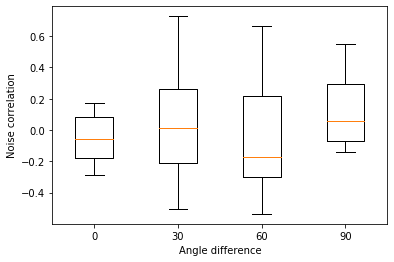

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1)
data = []
for angle_dist, corrs in angle_dist_to_corrs.items():
    data.append(corrs)
ax.boxplot(data)
ax.set_xticklabels(['0', '30', '60', '90'])
ax.set_xlabel("Angle difference")
if corr_type == "TEMP_CORR_AVG":
    ax.set_ylabel("Signal correlation")
elif corr_type == "NOISE_CORR":
    ax.set_ylabel("Noise correlation")
#TODO: Just manually label the n's

for angle_dist, corrs in angle_dist_to_corrs.items():
    print(angle_dist, min(corrs), max(corrs), np.mean(corrs), np.std(corrs), len(corrs))

In [46]:
"""
Unused code that might be useful again someday
"""
"""
import seaborn as sns;
ser = pd.Series(list(dir_pairs_to_corrs.values()),
                  index=pd.MultiIndex.from_tuples(dir_pairs_to_corrs.keys()))
df = ser.unstack().fillna(0)
df = df.sort_index(axis=0 ,ascending=False)
sns.heatmap(df, center=0)

# For each angle, which angle groups are most correlated with it?
for dir1 in dirs:
    dir_partner_to_corr = {}
    for dir2 in dirs:
        key = (dir1, dir2)
        if key in dir_pairs_to_corrs:
            dir_partner_to_corr[dir2] = dir_pairs_to_corrs[key]
    desc_sorted_keys = sorted(dir_partner_to_corr, key=dir_partner_to_corr.get, reverse=True)
    print (dir1, desc_sorted_keys)
# The orderings are:
# For 501836392: [2,4,1,1,4,2,3], not bad, for a length of 8. mean ~2.43 ordering.
#   And.. that was when I was using allen dsi. When using our dsi, it got worse :(
# For 501886692: [6,5,7,2,2,3] - v bad
# For 501717543: [7,7,6,7,2] - v bad

"""
0

0